# Gold: Selektive Demaskierung mit Audit-Log

1. **Selektive Demaskierung** - Nur autorisierte Benutzer können bestimmte PIIs sehen
2. **Audit-Logging** - Jeder Zugriff wird protokolliert
3. **Zugriffskontrolle** - Role-Based Access Control (RBAC)
4. **JSON-Export** - Für Compliance und Reporting

---

## Setup

In [1]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import json
import hashlib
import uuid

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Any
from dataclasses import dataclass, field
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

# Eigenes skript/modul
from src.pii_redactor import PIIRedactor, PIIType
from src.audit_logger import AuditLogger, User, AccessLevel, AuditEntry, create_test_users

---

## 1. Zugriffskontrolle

### 1.1 Role-Based Access Control (RBAC)

- definiert, wer auf welche Daten zugreifen darf
- hier anhand folgendem Beispiel:

| Access Level | Beschreibung | Zugriff auf |
|--------------|--------------|-------------|
| PUBLIC | Externe Nutzer | Keine PII |
| INTERNAL | Normale Mitarbeiter | Namen, E-Mails |
| CONFIDENTIAL | HR, Manager | + Telefon, Adresse, Geburtsdatum |
| RESTRICTED | Datenschutzbeauftragte | + SSN, Kreditkarten, IBAN |
| ADMIN | System-Admins | Vollzugriff |

In [2]:
# Test-User
test_users = create_test_users()

print("Alle Test-Benutzer:")
for role, user in test_users.items():
    print(f"\n{role.upper()}:")
    print(f"  ID: {user.user_id}")
    print(f"  Name: {user.username}")
    print(f"  Level: {user.access_level.name} ({user.access_level.value})")
    print(f"  Abteilung: {user.department}")
    print(f"  Rollen: {', '.join(user.roles)}")

Alle Test-Benutzer:

PUBLIC:
  ID: u001
  Name: guest_user
  Level: PUBLIC (0)
  Abteilung: External
  Rollen: viewer

INTERNAL:
  ID: u002
  Name: employee_standard
  Level: INTERNAL (1)
  Abteilung: Marketing
  Rollen: employee, data_viewer

CONFIDENTIAL:
  ID: u003
  Name: hr_manager
  Level: CONFIDENTIAL (2)
  Abteilung: Human Resources
  Rollen: manager, hr_staff

RESTRICTED:
  ID: u004
  Name: data_protection_officer
  Level: RESTRICTED (3)
  Abteilung: Compliance
  Rollen: dpo, auditor

ADMIN:
  ID: u005
  Name: system_admin
  Level: ADMIN (4)
  Abteilung: IT
  Rollen: admin, superuser


### 1.2 PII-Zugriffsanforderungen
- welches Access Level für welche PIIs benötigt wird

In [3]:
pii_requirements = AuditLogger.PII_ACCESS_REQUIREMENTS

# --> nach Level gruppiert
by_level = {}
for pii_type, level in pii_requirements.items():
    if level.name not in by_level:
        by_level[level.name] = []
    by_level[level.name].append(pii_type)

for level_name in ['INTERNAL', 'CONFIDENTIAL', 'RESTRICTED']:
    if level_name in by_level:
        print(f"\n{level_name}:")
        for pii in by_level[level_name]:
            print(f"  • {pii}")


INTERNAL:
  • email
  • name

CONFIDENTIAL:
  • phone
  • address
  • date_of_birth
  • ip_address

RESTRICTED:
  • ssn
  • credit_card
  • iban
  • id_number


---

## 2. Audit-Logger Setup

### 2.1 Logger init

- Audit-Logger mit Begründungspflicht für alle Zugriffe --> stellt sicher, dass jeder Datenzugriff nachvollziehbar dokumentiert wird.

In [4]:
log_file = project_root / "exports" / "audit_log.jsonl"

audit_logger = AuditLogger(
    log_file=str(log_file),
    require_reason=True,  # --> Begründung für Zugriffe erforderlich
    max_entries_memory=1000
)

print(f"Log-Datei: {log_file}")

Log-Datei: /Volumes/Fanxiang S880E 2TB/M-APR/2_Semester/LLM/github-llm/pii-detection-llm/exports/audit_log.jsonl


### 2.2 Dokument mit PIIs maskieren und registrieren

--> gefundenen PIIs im Audit-System registrieren

In [5]:
# Beispieldokument
sample_document = """
VERTRAULICHE PERSONALAKTE

Name: Dr. Maria Schmidt
E-Mail: maria.schmidt@company.de
Telefon: +49 89 123456789
Geburtsdatum: 15.03.1985
Adresse: Leopoldstraße 42, 80802 München

Bankverbindung:
IBAN: DE89 3704 0044 0532 0130 00
Kontoinhaber: Dr. Maria Schmidt

Sozialversicherungsnummer: 12 150385 S 123

Gehalt: 75.000 EUR/Jahr
Letzte IP bei Login: 192.168.1.42
"""

# PII erkennen und maskieren
redactor = PIIRedactor(use_ner=True, ner_model="de_core_news_lg")

try:
    redaction_result = redactor.redact(sample_document, method="hybrid")
except:
    # Fallback ohne NER
    redactor = PIIRedactor(use_ner=False)
    redaction_result = redactor.redact(sample_document, method="regex")

print("MASKIERTES DOKUMENT:")
print(redaction_result.redacted_text)

NER-Modell 'de_core_news_lg' erfolgreich geladen.
MASKIERTES DOKUMENT:

[NAME_1] PERSONALAKTE

Name: [NAME_2]
E-Mail: [EMAIL_1]
Telefon: +[PHONE_1]
Geburtsdatum: [DATE_OF_BIRTH_1]
Adresse: [ADDRESS_1] 42, [PHONE_2] [ADDRESS_2]

Bankverbindung:
IBAN: [IBAN_1] 00
Kontoinhaber: [NAME_3]

Sozialversicherungsnummer: [SSN_1]

Gehalt: 75.000 EUR/Jahr
Letzte IP bei Login: [IP_ADDRESS_1]



In [6]:
# PIIs --> Audit-Logger
for match in redaction_result.matches:
    hash_value = audit_logger.register_pii(
        placeholder=match.placeholder,
        original=match.text,
        pii_type=match.pii_type.value
    )
    print(f"  {match.placeholder} → {match.pii_type.value} (Hash: {hash_value})")

print(f"\n{len(redaction_result.matches)} PIIs gefunden")

  [NAME_1] → name (Hash: dd825657c9fe9c4f)
  [NAME_2] → name (Hash: f2e76611316c3ca6)
  [EMAIL_1] → email (Hash: 8e401fd516e1709a)
  [PHONE_1] → phone (Hash: 150ec31d02352af3)
  [DATE_OF_BIRTH_1] → date_of_birth (Hash: 1e8962dcfc83dfb3)
  [ADDRESS_1] → address (Hash: 90a33493a05d4f1e)
  [PHONE_2] → phone (Hash: 326dc3cea6b093b3)
  [ADDRESS_2] → address (Hash: c075b9c24a3d0f0c)
  [IBAN_1] → iban (Hash: de12be61ad13570e)
  [NAME_3] → name (Hash: f2e76611316c3ca6)
  [SSN_1] → ssn (Hash: 83852b888a350d6b)
  [IP_ADDRESS_1] → ip_address (Hash: 84b4812195edd00e)

12 PIIs gefunden


---

## 3. Zugriffskontrolle

### 3.1 Role-Check-Funktion

- ob ein Benutzer auf bestimmte PII-Typen zugreifen darf.

In [7]:
def check_user_access(user: User, pii_type: str) -> dict:
    allowed, reason = audit_logger.check_access(user, pii_type)
    
    required_level = AuditLogger.PII_ACCESS_REQUIREMENTS.get(
        pii_type.lower(), 
        AccessLevel.RESTRICTED
    )
    
    return {
        'user': user.username,
        'user_level': user.access_level.name,
        'user_level_value': user.access_level.value,
        'pii_type': pii_type,
        'required_level': required_level.name,
        'required_level_value': required_level.value,
        'allowed': allowed,
        'reason': reason,
        'gap': user.access_level.value - required_level.value
    }

# Test
print("ZUGRIFFSMATRIX:\n")

pii_types_to_test = ['email', 'phone', 'iban', 'ssn']
users_to_test = ['public', 'internal', 'confidential', 'restricted', 'admin']

access_matrix = []
for user_key in users_to_test:
    user = test_users[user_key]
    row = {'User': user.username}
    for pii_type in pii_types_to_test:
        result = check_user_access(user, pii_type)
        # X = erlaubt sonst O
        row[pii_type.upper()] = 'X' if result['allowed'] else 'O'
    access_matrix.append(row)

access_df = pd.DataFrame(access_matrix)
print(access_df.to_string(index=False))

ZUGRIFFSMATRIX:

                   User EMAIL PHONE IBAN SSN
             guest_user     O     O    O   O
      employee_standard     X     O    O   O
             hr_manager     X     X    O   O
data_protection_officer     X     X    X   X
           system_admin     X     X    X   X


### 3.2 Demaskierung mit Audit-Trail

--> Benutzer versuchen, PIIs zu demaskieren --> Jeder Versuch wird vollständig protokolliert.

In [8]:
def demonstrate_demask_attempt(
    user: User, 
    placeholder: str, 
    reason: str = ""
) -> None:
    print(f"Benutzer: {user.username} ({user.access_level.name})")
    print(f"Angefordert: {placeholder}")
    print(f"Begründung: {reason if reason else '[KEINE]'}")
    
    # Demaskierung try
    original, entry = audit_logger.demask(
        placeholder=placeholder,
        user=user,
        reason=reason,
        ip_address="192.168.1.100",
        session_id=f"sess_{uuid.uuid4().hex[:8]}"
    )
    
    print(f"\nERGEBNIS:")
    print(f"Aktion: {entry.action}")
    print(f"Erfolg: {'JA' if entry.success else 'NEIN'}")
    if original:
        print(f"Demaskierter Wert: {original}")
    else:
        print(f"Grund: {entry.reason}")
    print(f"Audit-ID: {entry.entry_id}")
    print(f"Zeitstempel: {entry.timestamp}")

In [9]:
# 1. Public User versucht E-Mail zu sehen
print("\n[SZENARIO 1] Externer Nutzer versucht E-Mail zu sehen:")
demonstrate_demask_attempt(
    user=test_users['public'],
    placeholder="[EMAIL_1]",
    reason="Kunde möchte Kontaktdaten"
)

# 2. HR-Manager sieht Telefonnummer
print("\n[SZENARIO 2] HR-Manager sieht Telefonnummer:")
demonstrate_demask_attempt(
    user=test_users['confidential'],
    placeholder="[PHONE_1]",
    reason="Dringender Rückruf erforderlich für Gehaltsabrechnung"
)

# 3. Ohne Begründung
print("\n[SZENARIO 3] Zugriff ohne Begründung:")
demonstrate_demask_attempt(
    user=test_users['admin'],
    placeholder="[IBAN_1]",
    reason=""  # --> Keine Begründung
)

# 4. Admin mit Begründung
print("\n[SZENARIO 4] Admin mit valider Begründung:")
demonstrate_demask_attempt(
    user=test_users['admin'],
    placeholder="[IBAN_1]",
    reason="Audit-Anforderung für Jahresabschluss, Ticket #2024-1234"
)

# 5. Unbekannter Placeholder
print("\n[SZENARIO 5] Nicht existierender Placeholder:")
demonstrate_demask_attempt(
    user=test_users['admin'],
    placeholder="[UNKNOWN_99]",
    reason="Test-Anfrage"
)


[SZENARIO 1] Externer Nutzer versucht E-Mail zu sehen:
Benutzer: guest_user (PUBLIC)
Angefordert: [EMAIL_1]
Begründung: Kunde möchte Kontaktdaten

ERGEBNIS:
Aktion: DEMASK_DENIED
Erfolg: NEIN
Grund: Zugriff verweigert: PUBLIC < INTERNAL. Angefragte Begründung: Kunde möchte Kontaktdaten
Audit-ID: 74ebac5a-d2a0-4acd-a0d9-ced4288eeb4d
Zeitstempel: 2025-12-22T03:42:29.098521

[SZENARIO 2] HR-Manager sieht Telefonnummer:
Benutzer: hr_manager (CONFIDENTIAL)
Angefordert: [PHONE_1]
Begründung: Dringender Rückruf erforderlich für Gehaltsabrechnung

ERGEBNIS:
Aktion: DEMASK_SUCCESS
Erfolg: JA
Demaskierter Wert: 49 89 123456789
Audit-ID: 410d1874-2c79-4401-8d17-a0fe51dbe1f7
Zeitstempel: 2025-12-22T03:42:29.099129

[SZENARIO 3] Zugriff ohne Begründung:
Benutzer: system_admin (ADMIN)
Angefordert: [IBAN_1]
Begründung: [KEINE]

ERGEBNIS:
Aktion: DEMASK_ATTEMPT
Erfolg: NEIN
Grund: Begründung erforderlich aber nicht angegeben
Audit-ID: 8d159949-7b76-4c1d-8e1d-bb8e209749c4
Zeitstempel: 2025-12-22T03:42

---

## 4. Batch-Demaskierung

- berechtigte Benutzer können alle PIIs in einem Text demaskiert werden

In [10]:
def batch_demask_document(
    masked_text: str,
    user: User,
    reason: str
) -> Tuple[str, List[AuditEntry]]:
    demasked_text, entries = audit_logger.batch_demask(
        text=masked_text,
        user=user,
        reason=reason,
        ip_address="192.168.1.100",
        session_id=f"batch_{uuid.uuid4().hex[:8]}"
    )
    
    return demasked_text, entries

# Test: HR-Manager demaskiert Dokument
print("BATCH-DEMASKIERUNG FÜR HR-MANAGER")

hr_user = test_users['confidential']
demasked, entries = batch_demask_document(
    masked_text=redaction_result.redacted_text,
    user=hr_user,
    reason="Vorbereitung Mitarbeitergespräch, Termin morgen 10:00"
)

print(f"\nBenutzer: {hr_user.username}")
print(f"Zugriffe versucht: {len(entries)}")
print(f"Erfolgreich: {sum(1 for e in entries if e.success)}")
print(f"Verweigert: {sum(1 for e in entries if not e.success)}")

print("\nDemaskiertes Dokument:")
print("-" * 40)
print(demasked if len(demasked) > 500 else demasked)

BATCH-DEMASKIERUNG FÜR HR-MANAGER

Benutzer: hr_manager
Zugriffe versucht: 12
Erfolgreich: 10
Verweigert: 2

Demaskiertes Dokument:
----------------------------------------

VERTRAULICHE PERSONALAKTE

Name: Dr. Maria Schmidt
E-Mail: maria.schmidt@company.de
Telefon: +49 89 123456789
Geburtsdatum: 15.03.1985
Adresse: Leopoldstraße 42, 80802 München

Bankverbindung:
IBAN: [IBAN_1] 00
Kontoinhaber: Dr. Maria Schmidt

Sozialversicherungsnummer: [SSN_1]

Gehalt: 75.000 EUR/Jahr
Letzte IP bei Login: 192.168.1.42



In [11]:
# Vergleich: Admin sieht alles
print("BATCH-DEMASKIERUNG FÜR ADMIN")

admin_user = test_users['admin']
admin_demasked, admin_entries = batch_demask_document(
    masked_text=redaction_result.redacted_text,
    user=admin_user,
    reason="System-Audit für Datenschutz-Prüfung, Ticket DSGVO-2024-Q4"
)

print(f"\nBenutzer: {admin_user.username}")
print(f"Zugriffe versucht: {len(admin_entries)}")
print(f"Erfolgreich: {sum(1 for e in admin_entries if e.success)}")

print("\nDemaskiertes Dokument:")
print(admin_demasked)

BATCH-DEMASKIERUNG FÜR ADMIN

Benutzer: system_admin
Zugriffe versucht: 12
Erfolgreich: 12

Demaskiertes Dokument:

VERTRAULICHE PERSONALAKTE

Name: Dr. Maria Schmidt
E-Mail: maria.schmidt@company.de
Telefon: +49 89 123456789
Geburtsdatum: 15.03.1985
Adresse: Leopoldstraße 42, 80802 München

Bankverbindung:
IBAN: DE89 3704 0044 0532 0130 00
Kontoinhaber: Dr. Maria Schmidt

Sozialversicherungsnummer: 12 150385 S 123

Gehalt: 75.000 EUR/Jahr
Letzte IP bei Login: 192.168.1.42



---

## 5. Audit-Log Analyse

In [12]:
summary = audit_logger.get_summary()

print(f"\nZeitraum: {summary.get('first_entry', 'N/A')} bis {summary.get('last_entry', 'N/A')}")
print(f"Gesamte Einträge: {summary.get('total_entries', 0)}")
print(f"Erfolgreiche Zugriffe: {summary.get('successful_accesses', 0)}")
print(f"Verweigerte Zugriffe: {summary.get('denied_accesses', 0)}")
print(f"Eindeutige Benutzer: {summary.get('unique_users', 0)}")

print("\nZugriffe nach Benutzer:")
for user_id, count in summary.get('accesses_by_user', {}).items():
    print(f"  {user_id}: {count}")

print("\nZugriffe nach PII-Typ:")
for pii_type, count in summary.get('accesses_by_pii_type', {}).items():
    print(f"  {pii_type}: {count}")

print("\nZugriffe nach Aktion:")
for action, count in summary.get('accesses_by_action', {}).items():
    print(f"  {action}: {count}")


Zeitraum: 2025-12-22T03:42:29.098521 bis 2025-12-22T03:42:29.107536
Gesamte Einträge: 29
Erfolgreiche Zugriffe: 24
Verweigerte Zugriffe: 5
Eindeutige Benutzer: 3

Zugriffe nach Benutzer:
  u001: 1
  u003: 13
  u005: 15

Zugriffe nach PII-Typ:
  email: 3
  phone: 5
  unknown: 2
  iban: 3
  name: 6
  date_of_birth: 2
  address: 4
  ssn: 2
  ip_address: 2

Zugriffe nach Aktion:
  DEMASK_DENIED: 3
  DEMASK_SUCCESS: 24
  DEMASK_ATTEMPT: 2


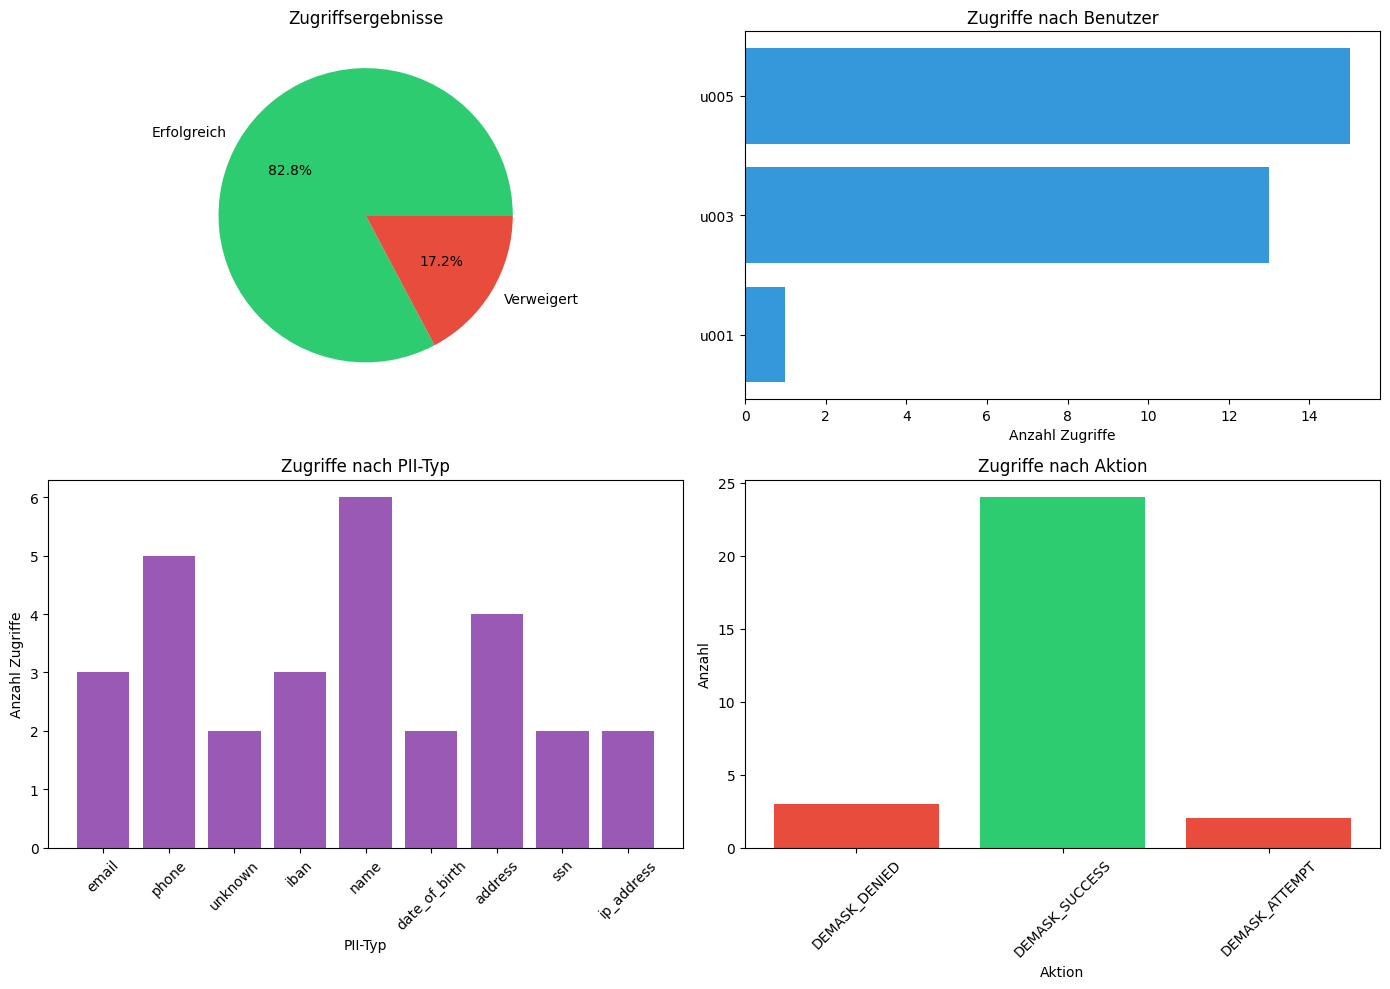

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --> Erfolg bei zugriff vs. verweigert
success_data = {
    'Erfolgreich': summary.get('successful_accesses', 0),
    'Verweigert': summary.get('denied_accesses', 0)
}
colors = ['#2ecc71', '#e74c3c']
axes[0, 0].pie(success_data.values(), labels=success_data.keys(), autopct='%1.1f%%', colors=colors)
axes[0, 0].set_title('Zugriffsergebnisse')

# --> Zugriffe nach Benutzer
user_data = summary.get('accesses_by_user', {})
if user_data:
    axes[0, 1].barh(list(user_data.keys()), list(user_data.values()), color='#3498db')
    axes[0, 1].set_xlabel('Anzahl Zugriffe')
    axes[0, 1].set_title('Zugriffe nach Benutzer')

# Zugriffe nach PII-Typ
pii_data = summary.get('accesses_by_pii_type', {})
if pii_data:
    axes[1, 0].bar(list(pii_data.keys()), list(pii_data.values()), color='#9b59b6')
    axes[1, 0].set_xlabel('PII-Typ')
    axes[1, 0].set_ylabel('Anzahl Zugriffe')
    axes[1, 0].set_title('Zugriffe nach PII-Typ')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Zugriffe nach Aktion --> was gemacht?
action_data = summary.get('accesses_by_action', {})
if action_data:
    colors_action = ['#2ecc71' if 'SUCCESS' in k else '#e74c3c' for k in action_data.keys()]
    axes[1, 1].bar(list(action_data.keys()), list(action_data.values()), color=colors_action)
    axes[1, 1].set_xlabel('Aktion')
    axes[1, 1].set_ylabel('Anzahl')
    axes[1, 1].set_title('Zugriffe nach Aktion')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(project_root / 'exports' / 'audit_visualization.png', dpi=150)
plt.show()

---

## 6. Export des Audit-Logs

In [14]:
export_path = project_root / 'exports' / 'audit_log_export.json'
json_export = audit_logger.export_json(filepath=str(export_path))

print(f"\nExportiert nach: {export_path}")
print(f"Dateigröße: {export_path.stat().st_size / 1024:.2f} KB")

# Vorschau
print("\nJSON-Vorschau (erste 1000 Zeichen):")
print(json_export[:1000])


Exportiert nach: /Volumes/Fanxiang S880E 2TB/M-APR/2_Semester/LLM/github-llm/pii-detection-llm/exports/audit_log_export.json
Dateigröße: 20.33 KB

JSON-Vorschau (erste 1000 Zeichen):
{
  "export_timestamp": "2025-12-22T03:42:29.458038",
  "total_entries": 29,
  "entries": [
    {
      "entry_id": "74ebac5a-d2a0-4acd-a0d9-ced4288eeb4d",
      "timestamp": "2025-12-22T03:42:29.098521",
      "user": {
        "user_id": "u001",
        "username": "guest_user",
        "access_level": "PUBLIC",
        "department": "External",
        "roles": [
          "viewer"
        ]
      },
      "action": "DEMASK_DENIED",
      "pii_type": "email",
      "placeholder": "[EMAIL_1]",
      "original_hash": "8e401fd516e1709a",
      "success": false,
      "reason": "Zugriff verweigert: PUBLIC < INTERNAL. Angefragte Begründung: Kunde möchte Kontaktdaten",
      "ip_address": "192.168.1.100",
      "session_id": "sess_6e1051c5",
      "additional_data": {}
    },
    {
      "entry_id": "410d187

In [15]:
audit_entries_data = []
for entry in audit_logger.entries:
    audit_entries_data.append({
        'Zeitstempel': entry.timestamp,
        'Benutzer': entry.user.username,
        'Level': entry.user.access_level.name,
        'Aktion': entry.action,
        'PII-Typ': entry.pii_type,
        'Erfolg': 'X' if entry.success else 'O', # --> erfolg = X sonst O
        'Begründung': entry.reason[:30] + '...' if len(entry.reason) > 30 else entry.reason
    })

audit_df = pd.DataFrame(audit_entries_data)

display(audit_df)

,Zeitstempel,Benutzer,Level,Aktion,PII-Typ,Erfolg,Begründung
0,2025-12-22T03:42:29.098521,guest_user,PUBLIC,DEMASK_DENIED,email,O,Zugriff verweigert: PUBLIC < I...
1,2025-12-22T03:42:29.099129,hr_manager,CONFIDENTIAL,DEMASK_SUCCESS,phone,X,Dringender Rückruf erforderlic...
2,2025-12-22T03:42:29.099232,system_admin,ADMIN,DEMASK_ATTEMPT,unknown,O,Begründung erforderlich aber n...
3,2025-12-22T03:42:29.099321,system_admin,ADMIN,DEMASK_SUCCESS,iban,X,Audit-Anforderung für Jahresab...
4,2025-12-22T03:42:29.099403,system_admin,ADMIN,DEMASK_ATTEMPT,unknown,O,Placeholder nicht gefunden
5,2025-12-22T03:42:29.102988,hr_manager,CONFIDENTIAL,DEMASK_SUCCESS,name,X,Vorbereitung Mitarbeitergesprä...
6,2025-12-22T03:42:29.103186,hr_manager,CONFIDENTIAL,DEMASK_SUCCESS,name,X,Vorbereitung Mitarbeitergesprä...
7,2025-12-22T03:42:29.103287,hr_manager,CONFIDENTIAL,DEMASK_SUCCESS,email,X,Vorbereitung Mitarbeitergesprä...
8,2025-12-22T03:42:29.103334,hr_manager,CONFIDENTIAL,DEMASK_SUCCESS,phone,X,Vorbereitung Mitarbeitergesprä...
9,2025-12-22T03:42:29.103373,hr_manager,CONFIDENTIAL,DEMASK_SUCCESS,date_of_birth,X,Vorbereitung Mitarbeitergesprä...


---

## 7. Integration mit LLM

In [ ]:
LLM_AVAILABLE = False
llm = None

try:
    from llama_cpp import Llama
    
    possible_paths = [
        Path.home() / ".cache" / "llama" / "llama-3.2-3b-q4km.gguf",
        Path("/pii-detection-llm/models/llama-3.2-3b-q4km/llama-3.2-3b-instruct-q4_k_m.gguf"),
    ]
    
    for path in possible_paths:
        if path.exists():
            llm = Llama(model_path=str(path), n_ctx=2048, n_threads=4, verbose=False)
            LLM_AVAILABLE = True
            print(f"Modell geladen: {path.name}")
            break
    
    if not LLM_AVAILABLE:
        print("Modell nicht gefunden")
except ImportError:
    print("Modell nicht installiert")

llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64

Modell geladen: llama-3.2-3b-instruct-q4_k_m.gguf


In [17]:
def secure_llm_query(
    query: str,
    context: str,
    user: User,
    reason: str
) -> dict:
    
    # Kontext für Benutzer anpassen
    user_context, access_entries = audit_logger.batch_demask(
        text=context,
        user=user,
        reason=reason
    )
    
    # LLM-Anfrage
    prompt = f"""Beantworte die Frage basierend auf dem Kontext.

Kontext:
{user_context}

Frage: {query}

Antwort:"""

    if LLM_AVAILABLE:
        response = llm(prompt, max_tokens=200, stop=["\n\n"])
        answer = response['choices'][0]['text'].strip()
    else:
        answer = f"[Simulation] Basierend auf dem Kontext mit {sum(1 for e in access_entries if e.success)} demaskierten PIIs."
    
    # Antwort auf PII-Leakage prüfen
    return {
        'query': query,
        'user': user.username,
        'access_level': user.access_level.name,
        'pii_accessed': sum(1 for e in access_entries if e.success),
        'pii_denied': sum(1 for e in access_entries if not e.success),
        'answer': answer,
        'audit_ids': [e.entry_id for e in access_entries]
    }

# Test --> Verschiedene Benutzer stellen dieselbe Frage
query = "Wie kann ich den Mitarbeiter kontaktieren?"

for user_type in ['public', 'internal', 'admin']:
    user = test_users[user_type]
    result = secure_llm_query(
        query=query,
        context=redaction_result.redacted_text,
        user=user,
        reason=f"Kundenanfrage bearbeiten - User: {user.username}"
    )
    
    print(f"\n{result['user']} ({result['access_level']}):")
    print(f"PIIs gesehen: {result['pii_accessed']}, verweigert: {result['pii_denied']}")
    print(f"Antwort: {result['answer'][:150]}..." if len(result['answer']) > 150 else f"   Antwort: {result['answer']}")


guest_user (PUBLIC):
PIIs gesehen: 0, verweigert: 12
   Antwort: Kontaktieren Sie [NAME_2] über die folgenden Möglichkeiten:

employee_standard (INTERNAL):
PIIs gesehen: 4, verweigert: 8
   Antwort: Dr. Schmidt kann über E-Mail auf mich zugreifen. Sie kann auch mich auf der Telefonnummer [PHONE_2] erreichen.

system_admin (ADMIN):
PIIs gesehen: 12, verweigert: 0
Antwort: Sie können Dr. Schmidt kontaktieren, indem Sie die E-Mail-Adresse maria.schmidt@company.de oder die Telefonnummer +49 89 123456789 anrufen. Alternativ...


## Quellen und Referenzen

1. **Carlini, N., Tramer, F., Wallace, E., et al. (2021).** "Extracting Training Data from Large Language Models." *30th USENIX Security Symposium.* [https://arxiv.org/abs/2012.07805](https://arxiv.org/abs/2012.07805)

2. **Microsoft Presidio** - Open-Source Framework für PII-Erkennung und Anonymisierung. [https://github.com/microsoft/presidio](https://github.com/microsoft/presidio)

3. **DSGVO (Datenschutz-Grundverordnung)** - Verordnung (EU) 2016/679 des Europäischen Parlaments und des Rates. [https://eur-lex.europa.eu/eli/reg/2016/679/oj/deu](https://eur-lex.europa.eu/eli/reg/2016/679/oj/deu)

4. **NIST Privacy Framework** - Guidance on Privacy Risk Management. [https://www.nist.gov/privacy-framework](https://www.nist.gov/privacy-framework)

5. **OWASP Data Protection Cheat Sheet** - Best Practices für Datenschutz. [https://cheatsheetseries.owasp.org/cheatsheets/Input_Validation_Cheat_Sheet.html](https://cheatsheetseries.owasp.org/cheatsheets/Input_Validation_Cheat_Sheet.html)